In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

import re
import os
from glob import glob

# Analysis of Simulations
Simulations were run on a cluster using `simulation.py` with the output in the `data` directory.
I varied inter trial interval (average time between trials), the number of trials per condition (there are only two conditions), and the noise level.
One condition has a pre-set betaseries correlation at 0.0, while the other condition has a set correlation at 0.8, thus, a relatively large difference.

This notebook currently observes:
1. do the results output by nibetaseries correlation with the simulated ground truth?
  - how does this vary by iti/number of trials/noise level?
2. is there a significant contrast between the two conditions (weak and strong beta correlations)?
  - how does this vary by iti/number of trials/noise level?
3. what do the mean and spread of results output by nibetaseries look like relative to the simulated ground truth?
  - how does this vary by iti/number of trials/noise level?

## Data Preparation

In [2]:
# aggregate all the data files in the data directory
data_dir = '../data/'
data_files = glob(os.path.join(data_dir, "iti-*_ntrials-*_noise-*_simulation.tsv"))
data_regex = re.compile(r".*?iti-(?P<iti>[0-9]+)_ntrials-(?P<ntrials>[0-9]+)_noise-(?P<noise>0.[0-9]+)_simulation.tsv")

df_collector = []
for dfile in data_files:
    mch = re.match(data_regex, dfile)
    attr_dict = mch.groupdict()
    
    df = pd.read_csv(dfile, sep='\t')
    nrows = len(df.index)
    
    df_dict = {k: [float(v)] * nrows for k,v in attr_dict.items()}
    
    df_add = pd.DataFrame.from_dict(df_dict)
    
    df_final = pd.concat([df, df_add], axis=1)
    
    df_collector.append(df_final)

    
    

In [3]:

df_wide = pd.concat(df_collector, axis=0, ignore_index=True)
df_wide["id"] = df_wide.index
col_names = {"corr_ew": "corr_obs-weak",
             "corr_dr": "corr_obs-strong",
             "true_corr_dr": "corr_truth-strong",
             "true_corr_ew": "corr_truth-weak",
             "ntrials": "ntrials_tot"}
df_wide.rename(col_names, axis=1, inplace=True)

# show trials per condition (instead of total)
df_wide['ntrials_tot'] = df_wide.ntrials_tot.astype(int)
df_wide['ntrials'] = df_wide['ntrials_tot'] // 2

# effect size for observed 0.8 - 0.0
df_wide['corr_obs-delta'] = df_wide['corr_obs-strong'] - df_wide['corr_obs-weak']

# effect size for ground truth 0.8 - 0.0
df_wide['corr_truth-delta'] = df_wide['corr_truth-strong'] - df_wide['corr_truth-weak']

# discrepency between truth and observed for low
df_wide['corr_disc-weak'] = df_wide['corr_truth-weak'] - df_wide['corr_obs-weak']

# discrepency between truth and observed for high
df_wide['corr_disc-strong'] = df_wide['corr_truth-strong'] - df_wide['corr_obs-strong']
df_wide.head()

,num,corr_obs-weak,corr_truth-weak,corr_obs-strong,corr_truth-strong,snr,iti,ntrials_tot,noise,id,ntrials,corr_obs-delta,corr_truth-delta,corr_disc-weak,corr_disc-strong
0,0,-0.031667,-0.044370,0.061628,0.735546,1.428565,10.0,90,0.1,0,45,0.093295,0.779916,-0.012704,0.673918
1,1,0.167236,-0.382414,-0.059141,0.725196,1.369580,10.0,90,0.1,1,45,-0.226377,1.107610,-0.549650,0.784337
2,2,-0.021301,0.155121,0.111060,0.654097,1.441149,10.0,90,0.1,2,45,0.132360,0.498976,0.176421,0.543038
3,3,0.015464,0.212888,0.185867,0.596836,1.263267,10.0,90,0.1,3,45,0.170402,0.383948,0.197424,0.410969
4,4,-0.003093,0.097607,-0.019449,0.848929,1.498162,10.0,90,0.1,4,45,-0.016356,0.751322,0.100700,0.868378


In [4]:
# list the variables in order
itis = df_wide.iti.unique()
itis.sort()
ntrials = df_wide.ntrials.unique()
ntrials.sort()
noises = df_wide.noise.unique()
noises.sort()

In [5]:
noises_str = ["low", "medium", "high"]
noises_dict = {k:v for k,v in zip(noises, noises_str)}

In [6]:
# how well do the observed values correlate with the truth?
query = "noise == {noise} & iti == {iti} & ntrials == {ntrial}"
corr_dict = {'iti': [],
             'ntrials': [],
             'noise': [],
             'bsc_strength': [],
             'corr': [],
             }
for iti in itis[1:]:
    for ntrial in ntrials:
        for noise, noise_str in noises_dict.items():
            for strgth in ["weak", "strong"]:
                rquery = query.format(iti=str(iti),
                                      ntrial=str(ntrial),
                                      noise=str(noise))
                tmp_df = df_wide.query(rquery)
                corr = np.corrcoef(tmp_df[['corr_truth-' + strgth, 'corr_obs-' + strgth]], rowvar=False)[0,1]
                tmp_df[['corr_truth-' + strgth, 'corr_obs-' + strgth]]
                # print("iti: {iti}, ntrial: {ntrial}, noise: {noise}, str: {strgth} corr: {corr}".format(iti=str(iti), 
                #                                                                                         ntrial=str(ntrial),
                #                                                                                         noise=str(noise),
                #                                                                                         corr=str(corr),
                #                                                                                         strgth=strgth))
                corr_dict['iti'].append(iti)
                corr_dict['ntrials'].append(ntrial)
                corr_dict['noise'].append(noise_str)
                corr_dict['bsc_strength'].append(strgth)
                corr_dict['corr'].append(corr)

df_corr = pd.DataFrame.from_dict(corr_dict)
df_corr.head()

,iti,ntrials,noise,bsc_strength,corr
0,4.0,15,low,weak,0.422200
1,4.0,15,low,strong,0.270630
2,4.0,15,medium,weak,0.376096
3,4.0,15,medium,strong,0.266832
4,4.0,15,high,weak,0.039097


## Question 1: Correlate NibetaSeries results with Ground Truth

The higher the correlation, the more "reliable" NiBetaSeries is.

**Hypotheses**:
1. as iti increases the correlation should increase
2. as the number of trials increases the correlation should increase
3. as the noise increases the correlation should decrease
4. there should not be a difference if the ground truth is weak or strong

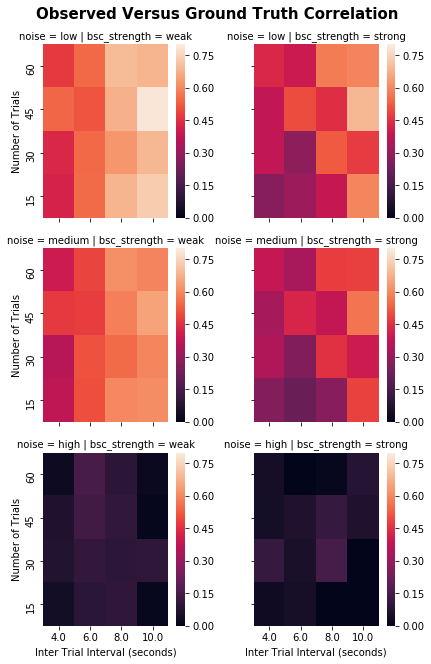

In [7]:
# show how well the observed correlations "correlate" with the ground truth correlations
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d = d[::-1]
    sns.heatmap(d, **kwargs)

fc = sns.FacetGrid(df_corr, col='bsc_strength', row='noise')
fc.map_dataframe(draw_heatmap, 'iti', 'ntrials', 'corr', vmin=0, vmax=0.8)
fc.fig.suptitle("Observed Versus Ground Truth Correlation", y=1.02, size=15, weight='heavy')
fc.set_xlabels("Inter Trial Interval (seconds)")
fc.set_ylabels("Number of Trials")
fc.savefig('../outputs/truth-obs_corr.svg')

## Question 1: Results

**Hypotheses**
1. supported, as iti increases, so does the correlation
2. supported*, there does appear to be an asymptote at 45 trials per condition
3. supported, and it appears to follow a non-linear trend, where after a threshold of noise is reached, the correlations are not recoverable.
4. not supported, there appears to be a stronger correspondance between ground truth and nibetaseries for the weak correlations

## Question 2: betaseries contrasts

The higher the statistic, the more likely a difference between conditions will be detected.

**Hypotheses**
1. as iti increases the statistic should increase
2. as the number of trials increases the statistic should increase
3. as the noise increases the statistic should decrease

In [8]:
ttest_dict = {
    'p_value': [],
    't_value': [],
    'source': [],
    'iti': [],
    'ntrials': [],
    'noise': [],
    'df': [],
}

for iti in itis[1:]:
    for ntrial in ntrials:
        for noise, noise_str in noises_dict.items():
            rquery = query.format(iti=str(iti),
                                      ntrial=str(ntrial),
                                      noise=str(noise))
            tmp_df = df_wide.query(rquery)
            for source in ["truth", "obs"]:
                t_val, p_val, deg_f = ttest_ind(tmp_df["corr_{src}-strong".format(src=source)],
                                            tmp_df["corr_{src}-weak".format(src=source)])
                
                ttest_dict['iti'].append(iti)
                ttest_dict['ntrials'].append(ntrial)
                ttest_dict['noise'].append(noise_str)
                ttest_dict['p_value'].append(p_val)
                ttest_dict['t_value'].append(t_val)
                ttest_dict['df'].append(deg_f)
                ttest_dict['source'].append(source)

ttest_df = pd.DataFrame.from_dict(ttest_dict)
ttest_df.head()
                

,p_value,t_value,source,iti,ntrials,noise,df
0,0.000000e+00,61.802717,truth,4.0,15,low,998.0
1,1.779914e-56,16.888598,obs,4.0,15,low,998.0
2,0.000000e+00,61.802717,truth,4.0,15,medium,998.0
3,1.767587e-39,13.741156,obs,4.0,15,medium,998.0
4,0.000000e+00,61.802717,truth,4.0,15,high,998.0


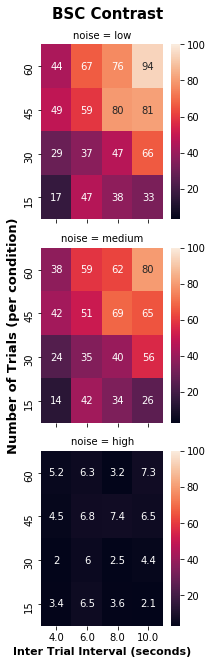

In [9]:
# show how t-values are modulated by trial number and iti
ttest_filt_df = ttest_df.query("source == 'obs'")

ft = sns.FacetGrid(ttest_filt_df, row='noise')
ft.map_dataframe(draw_heatmap, 'iti', 'ntrials', 't_value', vmin=3, vmax=100, annot=True)
ft.fig.suptitle("BSC Contrast", y=1.02, size=15, weight='heavy')
ft.set_xlabels("Inter Trial Interval (seconds)", size=11, weight='heavy')

ft.set_ylabels("", size=11, weight='heavy')
ft.axes[1, 0].set_ylabel("Number of Trials (per condition)", size=13, weight='heavy')
ft.savefig('../outputs/bsc_contrast.svg')

## Question 2: Results

**Hypotheses**
1. supported, as iti increases the statistic increases
2. supported, as the number of trials increases the statistic increases
3. supported, as the noise increases the statistic decreases, also a non-linear pattern

## Data Transformation

Make the data long, for other analyses

In [10]:
# make the correlations in one column
# ew = 0.0, dr = 0.8 (corr_str)
# (corr_ew, corr_dr) = observed, (true_corr_ew, true_corr_dr) = truth

df_long = pd.wide_to_long(df_wide, stubnames='corr', i='id', j="source-corr_str", sep="_", suffix="\\D+")
# id and source-corr_str became a part of the index
df_long.reset_index(inplace=True)
# split the source-corr_str columns
df_long[['source','corr_str']] = df_long['source-corr_str'].str.split("-",expand=True,)
# drop the no longer necessary columns
df_long.drop(labels=["id", "source-corr_str"], axis=1, inplace=True)
df_long.head()

,iti,noise,ntrials,snr,num,ntrials_tot,corr,source,corr_str
0,10.0,0.1,45,1.428565,0,90,-0.031667,obs,weak
1,10.0,0.1,45,1.369580,1,90,0.167236,obs,weak
2,10.0,0.1,45,1.441149,2,90,-0.021301,obs,weak
3,10.0,0.1,45,1.263267,3,90,0.015464,obs,weak
4,10.0,0.1,45,1.498162,4,90,-0.003093,obs,weak


In [11]:
df_long_raw = df_long.query("corr_str != 'delta' & source != 'disc'")
df_long_deriv = df_long.query("corr_str == 'delta' & source == 'disc'")

## Question 3: mean/spread of ground truth and nibetaseries results

**Hypotheses**
1. the nibetaseries (observed) results should have the same mean as the ground truth results
2. the nibetaseries (observed) results should have greater spread than the ground truth results

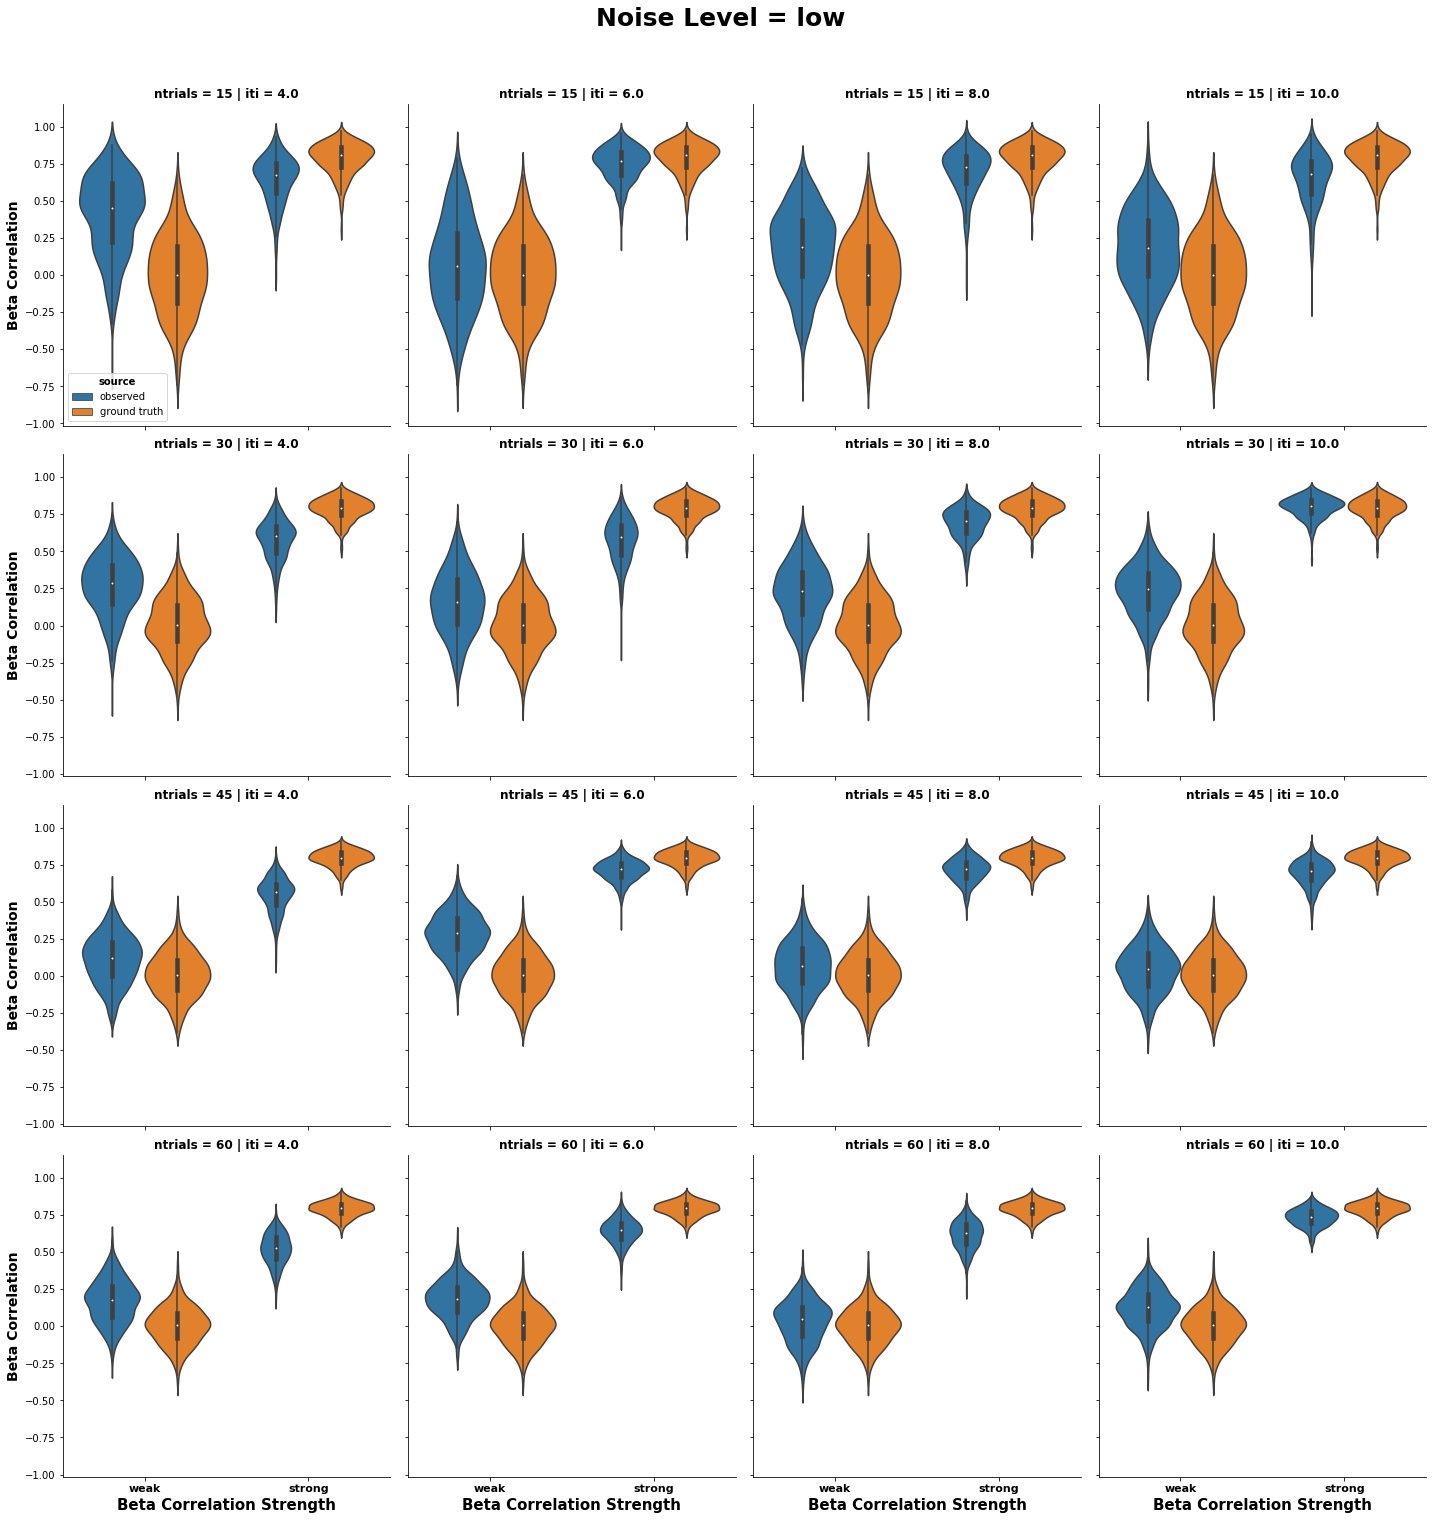

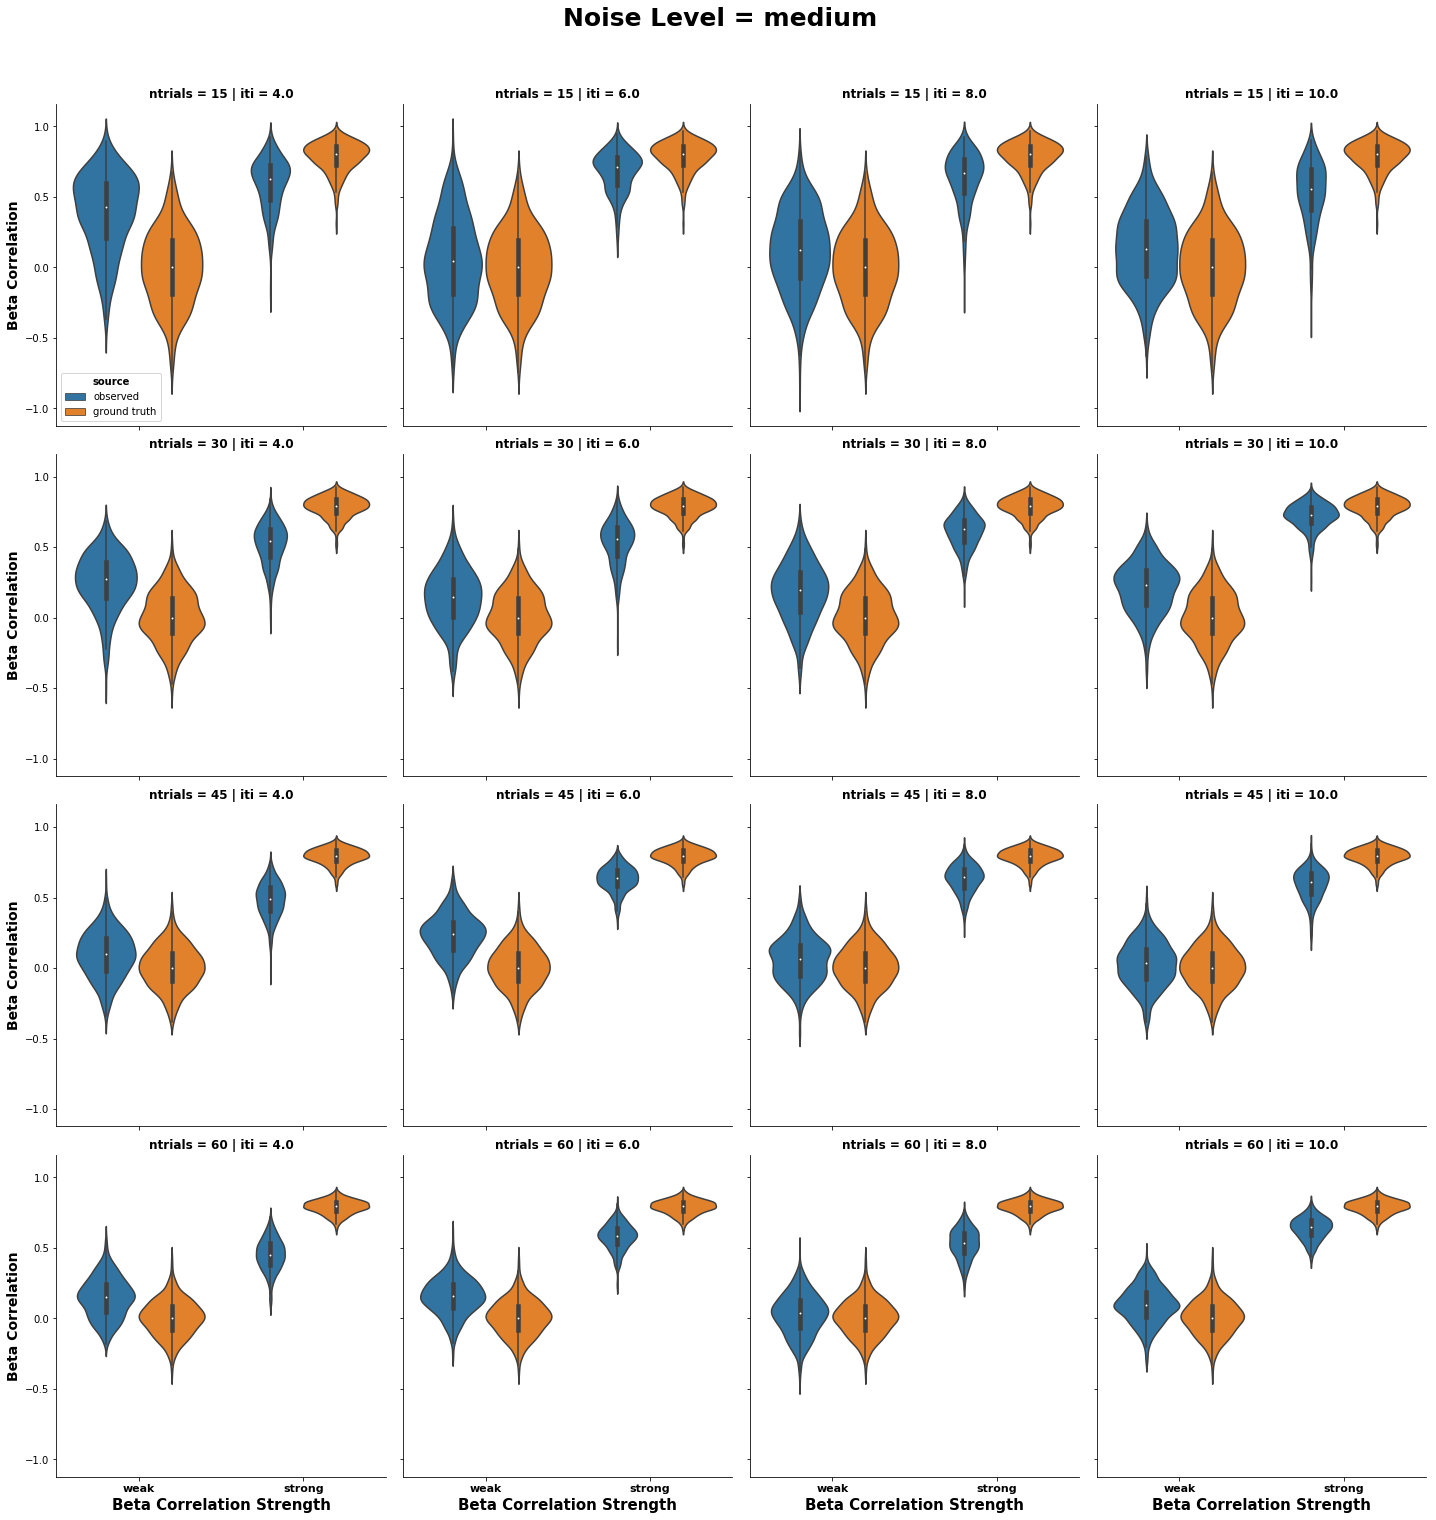

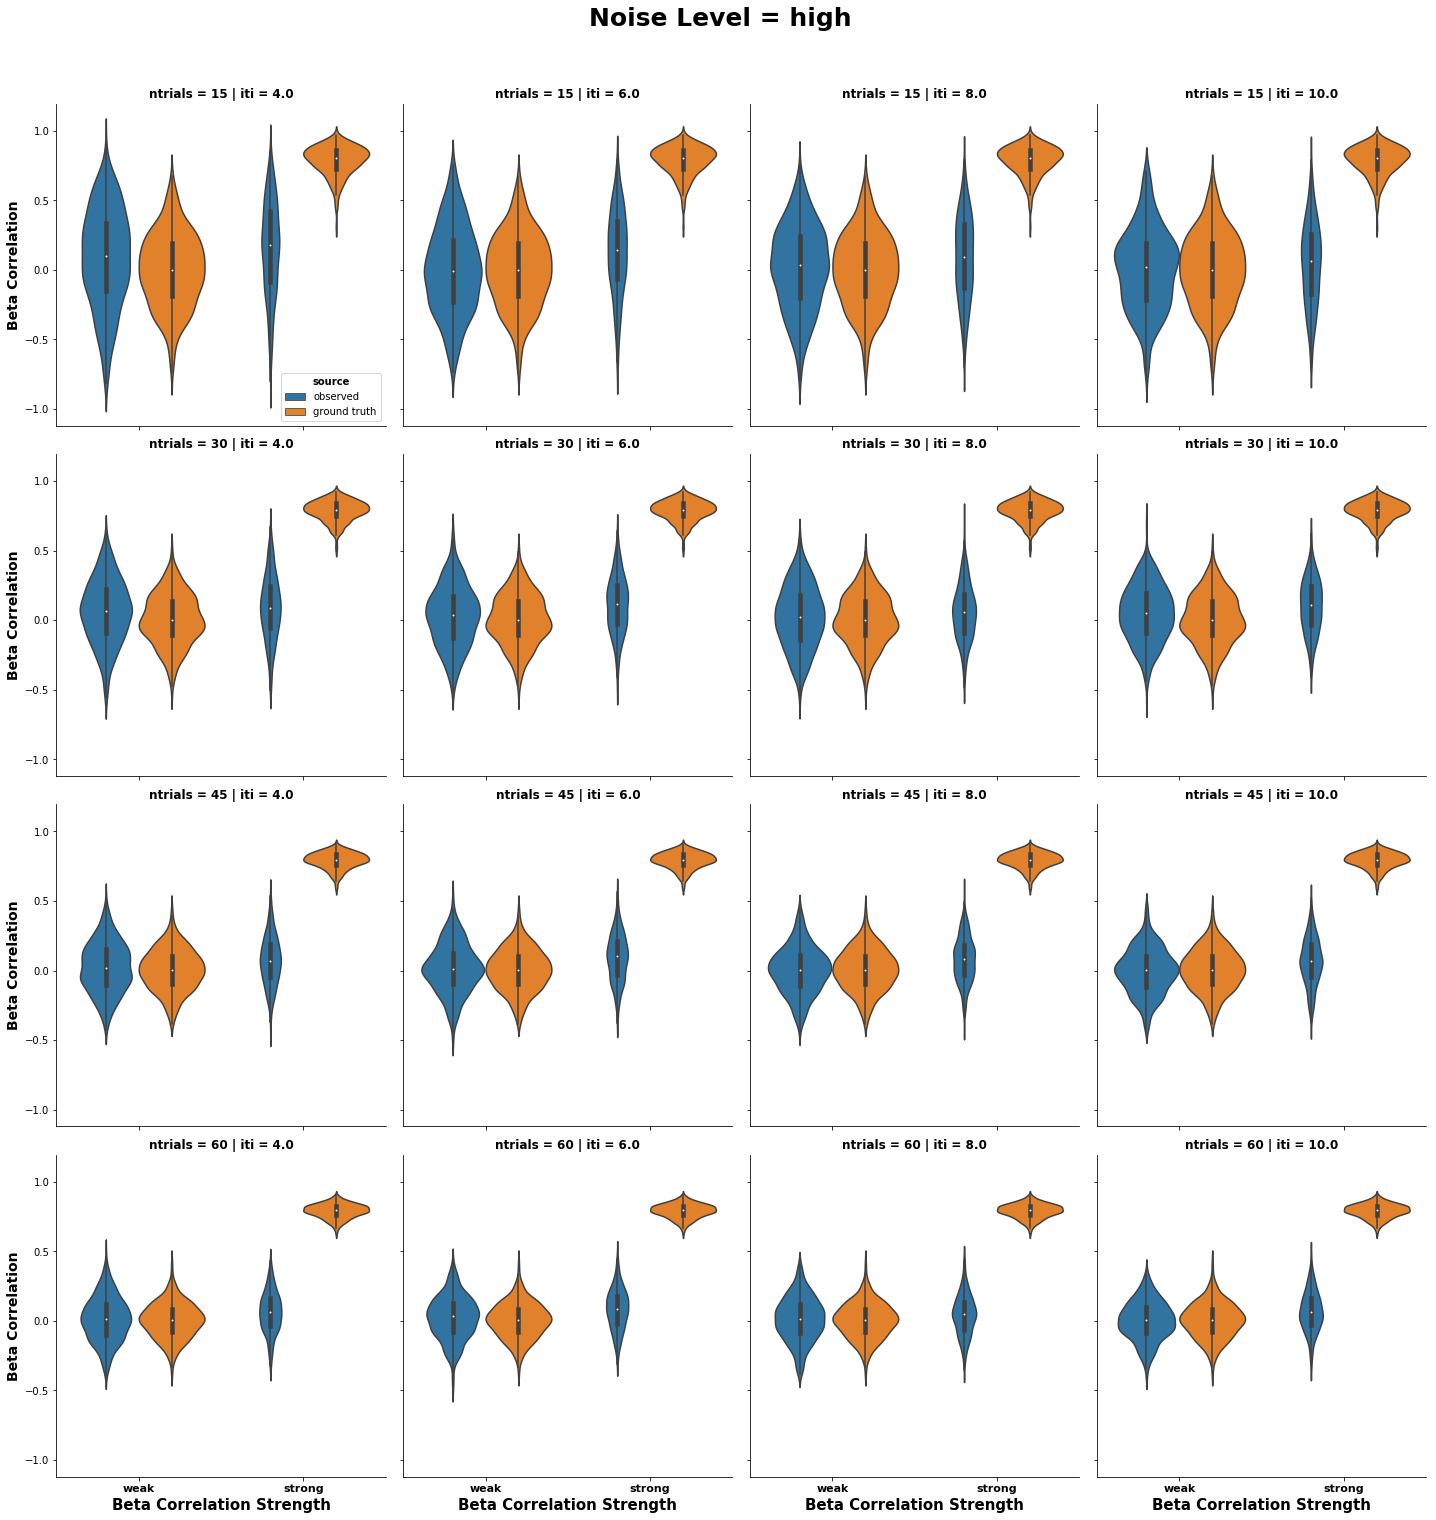

In [12]:
# show the average correlations across different conditions
for noise, noise_str in noises_dict.items():
    g = sns.catplot(x="corr_str", y="corr", hue="source",
                    col="iti", col_order=itis[1:],
                    row="ntrials", row_order=ntrials,
                    kind="violin", legend_out=False,
                    data=df_long_raw.query('noise == {noise} & iti != 2.'.format(noise=noise)))
    g.fig.suptitle('Noise Level = {noise}'.format(noise=noise_str), y=1.05, size=25, weight='heavy')
    g.set_xlabels("Beta Correlation Strength", size=15, weight='heavy')
    g.set_xticklabels(g.axes.flatten()[-1].get_xticklabels(), size=11, weight='heavy')
    g.set_ylabels("Beta Correlation", size=14, weight='heavy')
    lgnd_ax = g.axes[0,0]
    lb = ["observed", "ground truth"]
    lgnd_ax.legend_.set_title("source", prop={"size": 10, "weight": 'heavy'})
    for txt, lb in zip(lgnd_ax.legend_.get_texts(), lb):
        txt.set_text(lb)
    for ax in g.axes.flatten():
        ax.set_title(ax.get_title(), size=12, weight='heavy')
    g.savefig('../outputs/noise-{noise}_meancorr.svg'.format(noise=noise_str))
    plt.show()

## Question 3: Results

**Hypotheses**
1. not supported, the weak beta correlations have a positive bias and the strong beta correlations have a negative bias
2. supported, the nibetaseries (observed) results have greater spread than the ground truth results